C:\Users\15592\AppData\Local\Temp\ipykernel_13556\140395752.py:41: UserWarning: PySoundFile failed. Trying audioread instead.
  y, _ = librosa.load(file_path, sr=self.sr)


[Error] Skipping data/all-samples\viola\viola_D6_05_piano_arco-normal.mp3: 
Epoch 1, Loss: 0.4414
Epoch 2, Loss: 0.0816
Epoch 3, Loss: 0.0979
Epoch 4, Loss: 0.0477
Epoch 5, Loss: 0.0205

Precision: 0.992, Recall: 0.990, F1 Score: 0.991


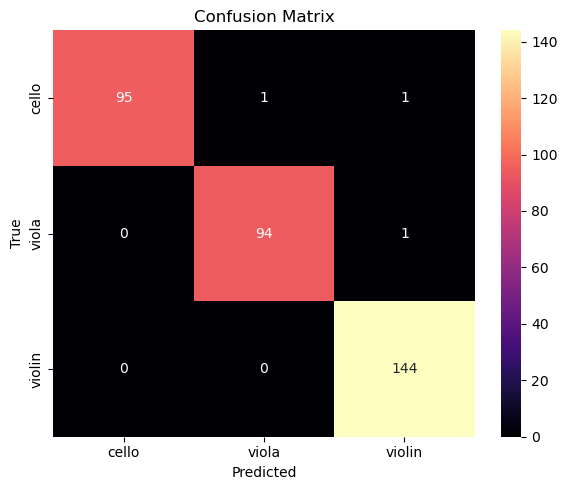

In [33]:
# Training and evaluation
# classes = ['violin', 'viola', 'cello', 'double bass', 'clarinet', 'bass clarinet', 'saxophone', 'flute',
#            'oboe', 'bassoon', 'contrabassoon', 'cor anglais', 'french horn', 'trombone', 'trumpet', 'tuba',
#             'guitar', 'mandolin', 'banjo', 'percussion']

import os
import sys
import numpy as np 
sys.path.append('./')

from encoder import ConformerEncoder, ConformerBlock

import librosa
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset setup
class TimbreDataset(Dataset):
    def __init__(self, root_dir, instrument_to_label, sample_rate=22050, duration_ms=500, n_mels=128):
        self.samples = []
        self.labels = []
        self.sr = sample_rate
        self.clip_len = int(sample_rate * duration_ms / 1000)
        self.n_mels = n_mels
        self.instrument_to_label = instrument_to_label

        for instrument, label in instrument_to_label.items():
            inst_dir = os.path.join(root_dir, instrument)
            if not os.path.isdir(inst_dir):
                continue  # Skip if not a valid directory
            for file in os.listdir(inst_dir):
                if file.endswith('.mp3'):
                    file_path = os.path.join(inst_dir, file)
                    try:
                        # Attempt to load the file
                        y, _ = librosa.load(file_path, sr=self.sr)
                        y_trim, _ = librosa.effects.trim(y, top_db=30)
                        clip = y_trim[:self.clip_len]
                        if len(clip) < self.clip_len:
                            clip = np.pad(clip, (0, self.clip_len - len(clip)))
                        mel = librosa.feature.melspectrogram(y=clip, sr=self.sr, n_mels=self.n_mels)
                        log_mel = librosa.power_to_db(mel, ref=np.max)
                        
                        # Ensure the time axis is fixed length
                        target_frames = 22  # whatever size you want
                        if log_mel.shape[1] < target_frames:
                            pad_width = target_frames - log_mel.shape[1]
                            log_mel = np.pad(log_mel, ((0, 0), (0, pad_width)), mode='constant')
                        else:
                            log_mel = log_mel[:, :target_frames]

                        self.samples.append(file_path)
                        self.labels.append(label)
                    except Exception as e:
                        # Log the issue and skip the corrupted file
                        print(f"[Error] Skipping {file_path}: {e}")
                        continue  # Skip this file and continue with the rest

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        file_path = self.samples[idx]
        label = self.labels[idx]
        try:
            y, _ = librosa.load(file_path, sr=self.sr)
            y_trim, _ = librosa.effects.trim(y, top_db=30)
            clip = y_trim[:self.clip_len]
            if len(clip) < self.clip_len:
                clip = np.pad(clip, (0, self.clip_len - len(clip)))
            mel = librosa.feature.melspectrogram(y=clip, sr=self.sr, n_mels=self.n_mels)
            log_mel = librosa.power_to_db(mel, ref=np.max)
            
            # Ensure the time axis is fixed length
            target_frames = 22  # whatever size you want
            if log_mel.shape[1] < target_frames:
                pad_width = target_frames - log_mel.shape[1]
                log_mel = np.pad(log_mel, ((0, 0), (0, pad_width)), mode='constant')
            else:
                log_mel = log_mel[:, :target_frames]

            return torch.tensor(log_mel, dtype=torch.float32).unsqueeze(0), torch.tensor(label, dtype=torch.long)
        except Exception as e:
            print(f"[Error] Skipping {file_path}: {e}")
            raise e



# Model definition
class ConformerClassifier(nn.Module):
    def __init__(self, input_dim=128, num_classes=58, num_blocks=4, hidden_dim=144, num_heads=4, dropout=0.1):
        super(ConformerClassifier, self).__init__()
        self.input_proj = nn.Conv1d(input_dim, hidden_dim, kernel_size=1)
        self.conformer_blocks = nn.Sequential(*[
            ConformerBlock(
                encoder_dim=hidden_dim,
                num_attention_heads=num_heads,
                feed_forward_expansion_factor=4,
                conv_expansion_factor=2,
                feed_forward_dropout_p=dropout,
                attention_dropout_p=dropout,
                conv_dropout_p=dropout,
                conv_kernel_size=31,
                half_step_residual=True
            ) for _ in range(num_blocks)
        ])
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.squeeze(1)  # From (B, 1, F, T) to (B, F, T)
        x = self.input_proj(x)  # (B, hidden_dim, T)
        x = x.transpose(1, 2)   # (B, T, hidden_dim) for conformer
        x = self.conformer_blocks(x)
        x = x.transpose(1, 2)   # Back to (B, hidden_dim, T)
        x = self.pooling(x).squeeze(-1)  # (B, hidden_dim)
        return self.classifier(x)

# Class mapping
classes = ["cello", "viola", "violin"]  # ✅ Single class (you might want to add more classes here)
instrument_to_label = {name: idx for idx, name in enumerate(classes)}

# Dataset + loaders
dataset = TimbreDataset("data/all-samples", instrument_to_label)
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=0)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=0)

# Device + model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ConformerClassifier(input_dim=128, num_classes=len(classes)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training loop
for epoch in range(5):  # Fewer epochs for initial testing
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        optimizer.zero_grad()
        preds = model(x_batch)
        loss = criterion(preds, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluation on validation set
# Evaluation on validation set
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        try:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            preds = model(x_batch)
            pred_labels = torch.argmax(preds, dim=1)
            all_preds.extend(pred_labels.cpu().numpy())
            all_targets.extend(y_batch.cpu().numpy())
        except Exception as e:
            print(f"[Skipping batch due to error]: {e}")
            continue

if len(all_targets) > 0 and len(all_preds) > 0:
    precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

    print(f"\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")

    # Confusion Matrix Plot
    cm = confusion_matrix(all_targets, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="magma")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()
else:
    print("[Warning] No predictions made — confusion matrix cannot be computed.")

# precision = precision_score(all_targets, all_preds, average='macro', zero_division=0)
# recall = recall_score(all_targets, all_preds, average='macro', zero_division=0)
# f1 = f1_score(all_targets, all_preds, average='macro', zero_division=0)

# print(f"\nPrecision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")

# # Confusion Matrix Plot
# cm = confusion_matrix(all_targets, all_preds)
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="magma")
# plt.xlabel("Predicted")
# plt.ylabel("True")
# plt.title("Confusion Matrix")
# plt.tight_layout()
# plt.show()

